# Episode 04: Add some utilities

Checking the board visually is fine for debugging but it does not work well when it comes to test a lot of board solutions.

This episode provides some utilities for the POC to come. The goal is to have reasonably efficient classes but not spend too much time on this step.

**Goals for this episode:**
- Answer recurring questions 
    - What are the width, height, nulber of cellss of the puzzle 
    - Given a board is it completed ? 
    - Does it break the clues ?
    - Are they cells left undefined ? 
    - Am I close to the goal ?


# 1. Elements from episodes 01, 02 and 03

In [1]:
from episode01 import clues2x2, clues5x5s, Board, BoardMark
from episode02 import solution2x2, solution5x5s, GameEngine
from episode03 import BoardPlotter

In [2]:
clues2x2

{'rows': [1, 2], 'cols': [2, 1]}

In [3]:
clues5x5s

{'rows': [1, 3, [1, 1], 3, 5], 'cols': [1, 4, [2, 2], 4, 1]}

Requirements listed in Episode 02 still uncovered
- a game engine which provides the game validation for try-and-error validation and solved board - for all kind of puzzles (we have tested 2x2 only)
- some operation thate were identified in episode 01: is the board completed, is the board valid
- a puzzle class with some operations to transform the clues and compute black count and cels count
- try-and-error and learning process will require something in between not done and done in order to improve on residual error or rewards: number of cells completed/undefined, number of errors, number of valid cells


# 2. Experiments

## 2.1 Get the number of blacks from clues

In [4]:
total_blacks = sum(clues2x2['rows'])
total_blacks

3

In [5]:
assert total_blacks == 3

This does not work with split blocks like clues5x5s

The mix of integers and list results in an error
```
TypeError: unsupported operand type(s) for +: 'int' and 'list'
```

##  2.2. Normalize the clues 

Summing or scanning the clues in a consistent way is required for a lot of features (check for consistency, check whether given clues and computed fromthe board are the same).

We can transform the user-friendly list into a computer-friendly list 

In [6]:
# convert all integers into a list of one integer
f_norm_clue = lambda clue: clue if isinstance(clue, list) else [clue]

[f_norm_clue(clue) for clue in [1, 3, [1,1], 3, 5]]

[[1], [3], [1, 1], [3], [5]]

In [7]:
# norm clues
def get_norm_clues(some_clues):
    f_norm_clue = lambda clue: clue if isinstance(clue, list) else [clue]
    norm_clues = {
        'rows': [f_norm_clue(clue) for clue in some_clues['rows']],
        'cols': [f_norm_clue(clue) for clue in some_clues['cols']]
    }
    return norm_clues

get_norm_clues(clues5x5s)

{'rows': [[1], [3], [1, 1], [3], [5]], 'cols': [[1], [4], [2, 2], [4], [1]]}

In [8]:
assert get_norm_clues(clues5x5s) == {'rows': [[1], [3], [1, 1], [3], [5]], 'cols': [[1], [4], [2, 2], [4], [1]]} 

Does it still work for non split ?

In [9]:
assert get_norm_clues(clues2x2) == {'rows': [[1], [2]], 'cols': [[2], [1]]}

## 2.3. Get number of blacks from normalized clues

Now we can compute the sum a consistent way

In [10]:
get_norm_clues(clues5x5s) 

{'rows': [[1], [3], [1, 1], [3], [5]], 'cols': [[1], [4], [2, 2], [4], [1]]}

In [11]:
from itertools import chain
# chain flatten the list of list to prepare sum
list(chain.from_iterable(get_norm_clues(clues5x5s)['rows']))

[1, 3, 1, 1, 3, 5]

In [12]:
from itertools import chain
# we may want to compute sum by rows or by cols
# rows or cols may be passed as parameter
def get_total_blacks(some_norm_clues, axis='rows'):
    # chain flatten the list of list to prepare sum
    return sum(chain.from_iterable(some_norm_clues[axis]))

In [13]:
norm_clues5x5s = get_norm_clues(clues5x5s)
total_blacks = get_total_blacks(norm_clues5x5s)
total_blacks

14

In [14]:
assert total_blacks == 14

In [15]:
assert get_total_blacks(norm_clues5x5s, axis='cols') == 14

In [16]:
# Check clues for consistency

# number of blacks on rows and cols miust be the same
assert get_total_blacks(norm_clues5x5s, axis='rows') == get_total_blacks(norm_clues5x5s, axis='cols')

## 2.4. check numbers of cells left empty

Check for undefined cells existence

In [17]:
board2x2 = Board(clues2x2)
board2x2.mark(0, 1, BoardMark.FILLER) 
board2x2.mark(1, 1, BoardMark.BLACK) 
board2x2.prettyprint()

cols: 2 1
rows:
1
2
[['.' 'x']
 ['.' 'o']]


In [18]:
# filter the cells having an undegined value 
# reshaping in a list of lenght equald to the number of cells 
# avoid having to browse a list of lists
[ c for c in board2x2.states.reshape(4) if c == -1]

[-1, -1]

In [19]:
board2x2.states.shape

(2, 2)

In [20]:
# totézl number of cells
from operator import mul
from functools import reduce
reduce(mul, board2x2.states.shape)

4

TODO explain reduce

In [21]:
from operator import mul
from functools import reduce

def count_empty(a_board):
    length = reduce(mul, a_board.states.shape)
    count = len([ c for c in a_board.states.reshape(length) 
                         if c == -1])
    return count
  
count = count_empty(board2x2)
print(f"count_empty={count}")
assert count == 2

count_empty=2


Check for 5x5

In [22]:
clues = {
    'rows': [1, 3, [1,1], 3, 5],
    'cols': [1, 4, [2,2], 4, 1]
}

In [23]:
board5x5s = Board(clues5x5s)
board5x5s.mark(4, 0, BoardMark.BLACK) 
board5x5s.mark(2, 2, BoardMark.FILLER) 
board5x5s.prettyprint()
count = count_empty(board5x5s)
print(f"count_empty={count}")
assert count == reduce(mul, board5x5s.states.shape) - 2

cols: 1 4 [2, 2] 4 1
rows:
1
3
[1, 1]
3
5
[['.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.']
 ['.' '.' 'x' '.' '.']
 ['.' '.' '.' '.' '.']
 ['o' '.' '.' '.' '.']]
count_empty=23


## 2.5. Check whether board hold the clues

In [24]:
norm_clues2x2 = get_norm_clues(clues2x2)
board2x2 = Board(clues2x2)
board2x2.prettyprint()
board2x2.mark(0, 0, BoardMark.BLACK) 
board2x2.mark(0, 1, BoardMark.FILLER) 
board2x2.mark(1, 0, BoardMark.BLACK) 
board2x2.mark(1, 1, BoardMark.BLACK) 
board2x2.prettyprint()

cols: 2 1
rows:
1
2
[['.' '.']
 ['.' '.']]
cols: 2 1
rows:
1
2
[['o' 'x']
 ['o' 'o']]


In [25]:
rows = board2x2.states
rows

array([[1, 0],
       [1, 1]])

In [26]:
from itertools import groupby

In [27]:
# group cells by value and select groups where group key is 1 (BLACK)
[ [(k, *g) for k,g in groupby(line) if k==1]
  for line in rows
]
# it outputs tuples where the first element is the key, 
# and the rest are the elements in the 
# there are two list (one for each row)
# row 0 : has 1 black cell (1=BLACK key, 1=the cell)
# row 1 : has 2 black cells (1=BLACK key, 1,1=the cells)

[[(1, 1)], [(1, 1, 1)]]

In [28]:
# transform to a list of block length
blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
           for line in rows
]
print(f"blocks={blocks}")
assert blocks == norm_clues2x2['rows'] 

blocks=[[1], [2]]


In [29]:
assert blocks == norm_clues2x2['rows'] 

In [30]:
w = board2x2.states.shape[0]
h = board2x2.states.shape[1]
length = mul(w, h)
cols = [ [board2x2.states.reshape(length)[c+r*w]
         for r in range(0, h)]
         for c in range(0, w)]
cols

[[1, 1], [0, 1]]

In [31]:
blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
  for line in cols
]
print(f"blocks={blocks}")
assert blocks == norm_clues2x2['cols'] 

blocks=[[2], [1]]


In [32]:
def get_rows_blocks(a_board):
    rows = a_board.states
    blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
           for line in rows
    ]
    return blocks

def get_cols_blocks(a_board):
    w = a_board.states.shape[0]
    h = a_board.states.shape[1]
    length = mul(w, h)
    cols = [ [a_board.states.reshape(length)[c+r*w]
         for r in range(0, h)]
         for c in range(0, w)]
    blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
      for line in cols
    ]
    return blocks

In [33]:
assert get_rows_blocks(board2x2) == norm_clues2x2['rows'] 

In [34]:
assert get_cols_blocks(board2x2)  == norm_clues2x2['cols'] 

check 5x5s

In [35]:
board5x5s = Board(clues5x5s)
board5x5s.mark(4, 0, BoardMark.BLACK) 
board5x5s.mark(2, 2, BoardMark.FILLER) 
board5x5s.prettyprint()
count = count_empty(board5x5s)
print(f"count empty={count}")


cols: 1 4 [2, 2] 4 1
rows:
1
3
[1, 1]
3
5
[['.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.']
 ['.' '.' 'x' '.' '.']
 ['.' '.' '.' '.' '.']
 ['o' '.' '.' '.' '.']]
count empty=23


In [36]:
get_rows_blocks(board5x5s)

[[], [], [], [], [1]]

In [37]:
# 1 BLACK on row 4
assert get_rows_blocks(board5x5s) == [[], [], [], [], [1]]

In [38]:
get_cols_blocks(board5x5s)

[[1], [], [], [], []]

In [39]:
# 1 BLACK on col 0
assert get_cols_blocks(board5x5s) == [[1], [], [], [], []]

## 2.6. Get score

Score may be computed
- from the number of errors in try-and-error process
- from the number of differences between proposed solutiion and the known solutiion
- from the number of violations of the clues

In [65]:
# difference between proposed and expected

proposed = [1, 1, 0, 1]
expected = [1, 0, 1, 1]
[(p,e) for (p,e) in zip(proposed, expected)]

[(1, 1), (1, 0), (0, 1), (1, 1)]

In [67]:
[abs(p-e) for (p,e) in zip(proposed, expected)]

[0, 1, 1, 0]

In [70]:
errors = sum([abs(p-e) for (p,e) in zip(proposed, expected)])
errors

2

In [72]:
# score
(len(expected) - errors) / len(expected)

0.5

In [73]:
# take left empty into account
proposed = [1, -1, 0, 1]
[abs(p-e) for (p,e) in zip(proposed, expected) if p>=0]

[0, 1, 0]

In [75]:
errors = sum([abs(p-e) for (p,e) in zip(proposed, expected) if p>=0])
errors

1

In [78]:
empty = sum([abs(p) for p in proposed if p<0])
empty

1

In [79]:
# score
(len(expected) - errors - empty) / len(expected)

0.5

In [ ]:
# TODO score for board update

# 3. updated classes 

In [40]:
%reset -f

TODO

Some solver will do operations on clues without having a board. For instance evaluate the total number of blacks cells in order to randomly place an equal nulber of blacks.

The game rules must be a separate class.

In [41]:
from episode01 import clues2x2, clues5x5s, BoardMark
from episode02 import solution2x2, solution5x5s

## 3.1. New Puzzle class

TODO explain why puzzle out of game engine

In [42]:
from itertools import chain

class Puzzle:
    '''
    Describe the puzzle clues and constants derived from clues
    '''
    
    def __init__(self, some_clues):
        '''
        Puzzle constructor
        '''
        
        # given parameters
        self.given_clues = some_clues
        
        # normalize clues
        self.norm_clues = self.init_norm_clues()
        
        # compute board dimensions
        self.width = len(some_clues['cols']) 
        self.height = len(some_clues['rows']) 
        self.cells_count = self.width * self.height
        self.required_blacks_count = self.get_black_count()
        
        
    def init_norm_clues(self):
        '''
        Turn clues into a list of lists with one or more integers
        '''

        f_norm_clue = lambda clue: clue if isinstance(clue, list) else [clue]
        norm_clues = {
            'rows': [f_norm_clue(clue) for clue in self.given_clues['rows']],
            'cols': [f_norm_clue(clue) for clue in self.given_clues['cols']]
        }
        return norm_clues

    
    def get_black_count(self, axis='rows'):
        '''
        Compute the number of blacks cells required by the clues 
        for either rows or cols
        '''
        
        return sum(chain.from_iterable(self.norm_clues[axis]))
      
        
    def is_consistent(self):
        '''
        Check clues for consistency between rows and cols definition
        '''
        
        return self.get_black_count(axis='rows') == self.get_black_count(axis='cols')

Test 2x2

In [48]:
puzzle2x2 = Puzzle(clues2x2)
assert puzzle2x2.required_blacks_count == 3
assert puzzle2x2.norm_clues == {'rows': [[1], [2]], 
                              'cols': [[2], [1]]}
assert puzzle2x2.is_consistent()

Test 5x5s

In [44]:
puzzle5x5s = Puzzle(clues5x5s)
assert puzzle5x5s.required_blacks_count == 14
assert puzzle5x5s.norm_clues == {'rows': [[1], [3], [1, 1], [3], [5]], 
                              'cols': [[1], [4], [2, 2], [4], [1]]} 
assert puzzle5x5s.is_consistent()

In [45]:
# inbalanced clues
clues1 = {
    'rows': [1, 1],
    'cols': [2, 1]
}
puzzle1 = Puzzle(clues1)
print(f"blacks in rows={puzzle1.get_black_count(axis='rows')}")
print(f"blacks in cols={puzzle1.get_black_count(axis='cols')}")
assert not puzzle1.is_consistent()

blacks in rows=2
blacks in cols=3


## 3.2. Changes to the class Board 

use puzzle

In [46]:
import numpy as np
from enum import Enum
from itertools import groupby, chain
from operator import mul
from functools import reduce

# constants for mark lette
class BoardMark(Enum):
    INIT = -1
    FILLER = 0
    BLACK = 1

class Board:
    '''
    Manage the board.
    '''
    
    def __init__(self, a_puzzle):
        '''
        Board constructor
        '''
        # given parameters
        self.puzzle = a_puzzle
        
        # compute board dimensions
        self.width = a_puzzle.width
        self.height = a_puzzle.height
        self.cells_count = a_puzzle.cells_count
        
        # create board of type int, initialized with -1
        default_value = BoardMark.INIT.value
        self.states = np.full((self.height, self.width), default_value, dtype=int)
       
    
    def mark(self, row, col, mark):
        '''
        Mark a cell
        '''
        self.states[row, col] = mark.value

        
    def fill_all(self, states):
        '''
        Uodate all cells with states
        '''
        self.states.flat[:] = states 
        
        
    def count_empty(self):
        '''
        Evaluate how much of the board is filled
        '''
        length = reduce(mul, self.states.shape)
        count = len([ c for c in self.states.reshape(length) 
                             if c == BoardMark.INIT.value])
        return count    
    
        
    def prettyprint(self):
        '''
        Pretty print of the board 
        '''
        print("cols:", end=" ")
        print(*self.puzzle.given_clues['cols']) # * unpacks and remove []s
        print("rows:")
        [print(r) for r in self.puzzle.given_clues['rows']]
          
        marks_switcher = {-1: '.', 0: 'x', 1: 'o'}
        # for whatever reason lambda does not work here
        def f_marks(v):
            return marks_switcher[v]
        applyall = np.vectorize(f_marks)
        marks = applyall(self.states)
        print(marks)


TODO update by row/col 

test 2x2

In [49]:
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
board2x2.mark(0, 0, BoardMark.BLACK) 
board2x2.mark(0, 1, BoardMark.FILLER) 
assert board2x2.count_empty() == 2
board2x2.mark(1, 0, BoardMark.BLACK) 
board2x2.mark(1, 1, BoardMark.BLACK) 
board2x2.prettyprint()
assert board2x2.count_empty() == 0

cols: 2 1
rows:
1
2
[['o' 'x']
 ['o' 'o']]


In [50]:
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
board2x2.fill_all(solution2x2)
board2x2.prettyprint()
assert board2x2.count_empty() == 0

cols: 2 1
rows:
1
2
[['o' 'x']
 ['o' 'o']]


In [51]:
puzzle5x5s = Puzzle(clues5x5s)
board5x5s = Board(puzzle5x5s)
board5x5s.fill_all(solution5x5s)
board5x5s.prettyprint()
assert board5x5s.count_empty() == 0

cols: 1 4 [2, 2] 4 1
rows:
1
3
[1, 1]
3
5
[['x' 'x' 'o' 'x' 'x']
 ['x' 'o' 'o' 'o' 'x']
 ['x' 'o' 'x' 'o' 'x']
 ['x' 'o' 'o' 'o' 'x']
 ['o' 'o' 'o' 'o' 'o']]


## 3.3. Changes to class BoardPlotter

use puzzle

In [52]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

class BoardPlotter:
    '''
    Plot the board
    Require %matplotlib inline .
    '''
    
    cdict = {'red': [(0.0, 0.6196078431372549, 0.6196078431372549),
      (0.5, 1.0, 1.0),
      (1.0, 0.03137254901960784, 0.03137254901960784)],
     'green': [(0.0, 0.792156862745098, 0.792156862745098),
      (0.5, 1.0, 1.0),
      (1.0, 0.18823529411764706, 0.18823529411764706)],
     'blue': [(0.0, 0.8823529411764706, 0.8823529411764706),
      (0.5, 1.0, 1.0),
      (1.0, 0.4196078431372549, 0.4196078431372549)],
     'alpha': [(0.0, 1.0, 1.0),
      (0.5, 1.0, 1.0),
      (1.0, 1.0, 1.0)]}
    nono_cmap = LinearSegmentedColormap('nono', cdict)
    
    
    def __init__(self, a_board):
        '''
        Plotter contructor
        '''
        self.board = a_board
        self.clues = self.board.puzzle.given_clues
      
        def row_clue_to_label(v):
            #print(v)
            return str(v) if not isinstance(v, list) else ' '.join(map(str,v))
        self.rows_labels = list(map(row_clue_to_label, self.clues['rows']))

        def col_clue_to_label(v):
            #print(v)
            return str(v) if not isinstance(v, list) else '\n'.join(map(str,v))
        self.cols_labels = list(map(col_clue_to_label, self.clues['cols']))
    
    
    def show(self):
        '''
        Show the plotter
        '''
        # WARNING :  the board is row col, while the fig is col row
        data = self.board.states
        w = self.board.width
        h = self.board.height
        nc = self.board.width * self.board.height
        
        # set some canvas
        # guess the figure size 
        # 1 fits 2 cells
        # 2 fits 5 cols
        figw = int(w/2) 
        figh = int(h/2) 
        fig, ax = plt.subplots(figsize=(figw,figh))
        # draw a heatmap
        # ensure value range is -1 to 1
        heatmap = ax.pcolor(data, cmap=self.nono_cmap, vmin=-1, vmax=1)

        # ensure square cells
        ax.set_aspect("equal")

        # put the major ticks at the middle of each cell
        ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
        ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

        # put labels on top
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        

        # set labels
        column_labels = self.clues['cols']
        row_labels = self.clues['rows']

        ax.set_xticklabels(self.cols_labels, minor=False)
        ax.set_yticklabels(self.rows_labels, minor=False)


        # annotate fillers
        # expect (col,row) is (1,0) for row=0 col=1
        fillers_coordinates = [(p%w + 0.5, int(p/w) + 0.5) 
                               for (p,v) in enumerate(data.reshape(nc)) 
                               if v==0]
        # place an X in the center of each coordinate
        for coord in fillers_coordinates:
            plt.text(coord[0], coord[1], 'x', 
                 verticalalignment='center',
                 horizontalalignment='center',
                 fontsize='xx-large')

        plt.show()

tests

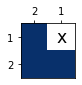

In [53]:
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
plotter2x2 = BoardPlotter(board2x2)
board2x2.fill_all(solution2x2)
plotter2x2.show()

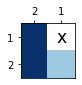

In [54]:
# not complete
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
plotter2x2 = BoardPlotter(board2x2)

board2x2.mark(0, 0, BoardMark.BLACK) 
board2x2.mark(0, 1, BoardMark.FILLER) 
board2x2.mark(1, 0, BoardMark.BLACK) 

assert board2x2.count_empty() > 0
plotter2x2.show()

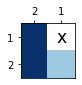

In [55]:
puzzle5x5s = Puzzle(clues5x5s)
board5x5s = Board(puzzle5x5s)
plotter5x5s = BoardPlotter(board2x2)

board5x5s.fill_all(solution5x5s)
plotter5x5s.show()

## 3.4. Changes to the class GameEngine

TODO

use puzlle

check whether rules are borcken

game progress utilities

In [117]:
class GameEngine:
    '''
    Provide utilities for this game
    '''
    
    def __init__(self, a_puzzle, a_solution):
        '''
        Engine constructor
        '''
            
        self.puzzle = a_puzzle
        self.solution = a_solution
        self.flat_solution = self.solution.reshape(self.puzzle.cells_count).tolist()
    
        # init a board
        self.board = Board(a_puzzle)
        self.plotter = BoardPlotter(self.board)
        
        # init score
        self.errors = 0
        
        
    def show_board(self):
        ''' 
        Plot the board
        '''
        self.plotter.show()  
        
        
    def is_action_valid(self, row, col, mark):
        ''' 
        Check whether an action is valid given a solution 
        '''
        okay = self.solution[row, col] == mark.value   
        if not okay:
            self.errors += 1
        return okay    
    
    
    def is_expected_solution(self, states_list):
        ''' 
        Check whether the states given a the regidtered solution 
        '''
        # compute the difference between given board and known solution
        self.errors = sum([abs(p-e) for (p,e) in zip(states_list, self.flat_solution) if p>=0])
        # board is okay when full and without errors
        return  states_list == self.flat_solution # must account for empty 
    
           
    def is_solved(self):
        '''
        Check whether the puzzle is solved
        '''
        
        done = True
        if done:
            done = self.board.count_empty() == 0
        if done:
            done = self.get_rows_blocks() == self.puzzle.norm_clues['rows']
        if done:
            done = self.get_cols_blocks() == self.puzzle.norm_clues['cols']
        return done
    
    
    def get_rows_blocks(self):
        '''
        Compute blocks for each rows
        '''
        
        rows = self.board.states
        blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
               for line in rows
        ]
        return blocks

    
    def get_cols_blocks(self):
        '''
        Compute blocks for each cols
        '''
        
        w = self.board.states.shape[0]
        h = self.board.states.shape[1]
        length = mul(w, h)
        cols = [ [self.board.states.reshape(length)[c+r*w]
             for r in range(0, h)]
             for c in range(0, w)]
        blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
          for line in cols
        ]
        return blocks

Test 2x2

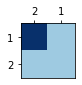

In [82]:
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board
board2x2.mark(0, 0, BoardMark.BLACK) 
assert board2x2.count_empty() == 3
game2x2.show_board()

In [83]:
game2x2.errors

0

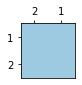

In [115]:
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board
game2x2.is_action_valid(0, 0, BoardMark.FILLER) 
assert game2x2.errors == 1
game2x2.show_board()

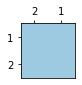

In [118]:
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board
game2x2.is_expected_solution([1,1,0,1]) 
assert game2x2.errors == 2
game2x2.show_board()

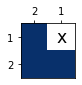

In [58]:
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board
board2x2.fill_all(solution2x2) 
assert game2x2.is_solved()
game2x2.show_board()

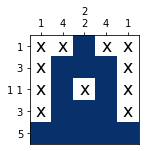

In [59]:
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution2x2)
board5x5s = game5x5s.board
board5x5s.fill_all(solution5x5s) 
assert game5x5s.is_solved()
game5x5s.show_board()

# 5. Wrap up

We have learned
- groupby

The class and solutions are saved in episode04.py.


5.1. Quick test of saved classes

In [ ]:
# reset all variables from tests
%reset -f

In [62]:
from episode04 import clues2x2, solution2x2, clues5x5s, solution5x5s
from episode04 import Puzzle, Board, BoardMark, GameEngine

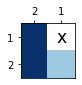

In [63]:
puzzle2x2 = Puzzle(clues2x2)
assert puzzle2x2.is_consistent()

board2x2 = Board(puzzle2x2)
plotter2x2 = BoardPlotter(board2x2)

board2x2.mark(0, 0, BoardMark.BLACK) 
board2x2.mark(0, 1, BoardMark.FILLER) 
board2x2.mark(1, 0, BoardMark.BLACK) 

assert board2x2.count_empty() == 1
plotter2x2.show()

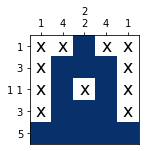

In [64]:
puzzle5x5s = Puzzle(clues5x5s)
assert puzzle5x5s.is_consistent()

game5x5s = GameEngine(puzzle5x5s, solution2x2)
board5x5s = game5x5s.board

board5x5s.fill_all(solution5x5s) 
assert game5x5s.is_solved()

game5x5s.show_board()